# BitTrack Project
## Send request and Get data

In [302]:
import requests
import csv
import json

import datetime
import time
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

# Time in UNIX format
month = 2629743
now = int(time.time())
start_time = now - 3*month
DATALENGTH = 720
ema_length = 50

url = f"http://api.coincap.io/v2/assets/bitcoin/history?interval=h1"
print(url)

# Request data from the API
response = requests.request("GET", url, headers={}, data={})
json_data = json.loads(response.text.encode('utf8'))
# print(json_data)
bitcoin_data = json_data["data"]

df = pd.DataFrame(bitcoin_data)
## Export data as a csv file
# df.to_csv('BTCUSD.csv', index=False)
print(df.sample)
# df.dtypes

# Filter only the columns we need
df = pd.DataFrame(bitcoin_data, columns=['time', 'priceUsd'])
# Get last 200 rows and REVERSE, newest price on top (index 0)
df = df[:-DATALENGTH-1:-1]
print(df.sample)

# Convert 'priceUsd' datatype to something numeric
df['priceUsd'] = pd.to_numeric(df['priceUsd'], errors='coerce', downcast='integer').fillna(0, downcast='infer')
df.dtypes
df.info()

http://api.coincap.io/v2/assets/bitcoin/history?interval=h1
<bound method NDFrame.sample of                    priceUsd           time          circulatingSupply  \
0    36725.5816752756869749  1624028400000  18737956.0000000000000000   
1    36456.7268604506673044  1624032000000  18737956.0000000000000000   
2    36699.8360965008607136  1624035600000  18738043.0000000000000000   
3    36367.5159857227546417  1624039200000  18738043.0000000000000000   
4    35403.6911941540001746  1624042800000  18738100.0000000000000000   
..                      ...            ...                        ...   
715  31761.1975660714668414  1626602400000  18743737.0000000000000000   
716  31700.0485155961280277  1626606000000  18743737.0000000000000000   
717  31794.7332044431923858  1626609600000  18743737.0000000000000000   
718  31763.0499059628597291  1626613200000  18743737.0000000000000000   
719  31728.4728578005085517  1626616800000  18743737.0000000000000000   

                         date  

In [303]:
# Check data 
prices = df['priceUsd']
print(prices)

719    31728.472858
718    31763.049906
717    31794.733204
716    31700.048516
715    31761.197566
           ...     
4      35403.691194
3      36367.515986
2      36699.836097
1      36456.726860
0      36725.581675
Name: priceUsd, Length: 720, dtype: float64


In [304]:
# Calculate and check last ema value 
count = 0
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

In [305]:
print("EMA50 H1:", ema(df['priceUsd'], count))

EMA50 H1: 31692.744396836602


In [306]:
# Process UNIX time to readable form
timeStamp =  df['time'].values.tolist()
timeStamp = [x / 1000 for x in timeStamp]

In [307]:
# Insert readable timeStamp column to 'df'
df['timeStamp'] = pd.to_datetime(timeStamp, unit='s')

In [308]:
# Check
df.sample

<bound method NDFrame.sample of               time      priceUsd           timeStamp
719  1626616800000  31728.472858 2021-07-18 14:00:00
718  1626613200000  31763.049906 2021-07-18 13:00:00
717  1626609600000  31794.733204 2021-07-18 12:00:00
716  1626606000000  31700.048516 2021-07-18 11:00:00
715  1626602400000  31761.197566 2021-07-18 10:00:00
..             ...           ...                 ...
4    1624042800000  35403.691194 2021-06-18 19:00:00
3    1624039200000  36367.515986 2021-06-18 18:00:00
2    1624035600000  36699.836097 2021-06-18 17:00:00
1    1624032000000  36456.726860 2021-06-18 16:00:00
0    1624028400000  36725.581675 2021-06-18 15:00:00

[720 rows x 3 columns]>

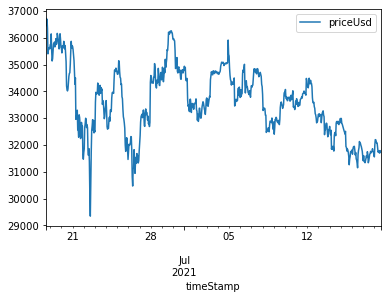

In [309]:
# Plot the data
df.plot(x ='timeStamp', y='priceUsd', kind = 'line')
plot.show()

## Calculate the possible EMA for each timeStamp
'possible' means timeStamp that have at lease 50 values before it. After that, we add EMA value along with the above figure.

In [310]:
short_df = df.head(DATALENGTH-ema_length)
short_df.reset_index()

,index,time,priceUsd,timeStamp
0,719,1626616800000,31728.472858,2021-07-18 14:00:00
1,718,1626613200000,31763.049906,2021-07-18 13:00:00
2,717,1626609600000,31794.733204,2021-07-18 12:00:00
3,716,1626606000000,31700.048516,2021-07-18 11:00:00
4,715,1626602400000,31761.197566,2021-07-18 10:00:00
...,...,...,...,...
665,54,1624222800000,35872.000133,2021-06-20 21:00:00
666,53,1624219200000,35501.056909,2021-06-20 20:00:00
667,52,1624215600000,35013.524411,2021-06-20 19:00:00
668,51,1624212000000,34697.013888,2021-06-20 18:00:00


In [311]:
short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))

<ipython-input-311-b2c0fb1e9939>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  short_df['EMA'] = np.zeros(( DATALENGTH-ema_length, 1))


In [312]:
# short_df['N'] = np.arange(len(short_df))
short_df.insert(loc=0, column='N', value=np.arange(len(short_df)))

In [313]:
# Try modifying a value in EMA column
# short_df.loc[713,'EMA'] = 999999
# Try accessing short_df
print(short_df['EMA'].iloc[-1])

0.0


In [314]:
# Finalize 'ema' function to run in for loop
def ema(prices, count, length = ema_length, smoothing = 2):
    multiplier = smoothing/(1+length)
    if count < length:
        # print(prices.iloc[count])
        price = (prices.iloc[count] * multiplier) 
        count += 1
        return price + ema(prices, count ) * (1 - multiplier)
    return prices.iloc[count]

# Calculate ema values and replace them into the dataframe
for i in range(0, DATALENGTH-ema_length):
    count = 0
    # short_df.iloc[ ?,4 ] => 'EMA' column
    # df['priceUsd'].iloc[ i: ] => use dataFrame from newest to the last 51st row
    short_df.iloc[ i,4 ] = ema( df['priceUsd'].iloc[ i: ], count )


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


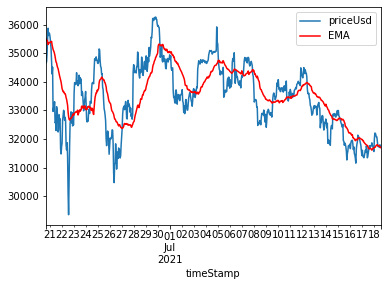

In [315]:
# Reference article https://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot
ax = plot.gca()
short_df.plot(kind='line',x='timeStamp',y='priceUsd', ax=ax)
short_df.plot(kind='line',x='timeStamp',y='EMA', color='red', ax=ax)
plot.show()

## Create a while loop to update price constantly

## Alarm when PRICE cross EMA

## Analyze profit/loss if trade base on EMA 

Strategy 1  
using data in the past 720 hours  
Long/Short when Price cross EMA50 in H1 timeframe, update each hour  
TP when +1000, move SL to entry  


Strategy 2  
using data in the past 720 hours  
with R:R=1:1, TP = SL = 5%  
TP 80% when reach target, move SL to entry


In [316]:
# check
df['timeStamp'].iloc[50]

Timestamp('2021-07-16 12:00:00')

In [317]:
balance = 1000
placed_order = 0
old_entry = 0

for i in reversed(range(0, DATALENGTH-ema_length-1)):
    count = 0
    old_price = df['priceUsd'].iloc[i+1]
    current_price = df['priceUsd'].iloc[i]
    timeStamp = df['timeStamp'].iloc[i]
    current_ema = ema( df['priceUsd'].iloc[i:], count )
    
    # TP if price moves 1000
    if (abs(current_price - old_entry) >= 1000):

        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        elif (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
              f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')

        placed_order = 0

    # Price going up
    if (old_price <= current_ema <= current_price):
        # If placed SELL order, close that previous SELL order
        if (placed_order == -1):
            balance = balance * (2 - current_price / old_entry)
            print(f'CLOSE SELL POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = 1
            print(f'BUY ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    # Price going down
    elif (old_price >= current_ema >= current_price):
        # If placed BUY order, close that previous BUY order
        if (placed_order == 1):
            balance = balance * current_price / old_entry
            print(f'CLOSE BUY POSITION ' + '='*45 + \
                f'\nEntry: {old_entry}  \nCurrent price: {current_price} \nBalance: {balance}\n')
            placed_order = 0
        # Place order if there's no position
        if (placed_order == 0):
            old_entry = current_price
            placed_order = -1
            print(f'SELL ' + '='*50 + \
                f'\nEntry: {old_entry}  \nBalance: {balance}\n')

    print(f'i = {i}')
    print(f'timeStamp = {timeStamp}')
    print(f'price = {current_price}')
    print(f'ema = {current_ema}\n')


i = 668
timeStamp = 2021-06-20 18:00:00
price = 34697.01388765832
ema = 35437.98051721546

i = 667
timeStamp = 2021-06-20 19:00:00
price = 35013.52441068804
ema = 35452.93776113538

BUY ==================================================
Entry: 35501.05690877834  
Balance: 1000

i = 666
timeStamp = 2021-06-20 20:00:00
price = 35501.05690877834
ema = 35411.62538558655

i = 665
timeStamp = 2021-06-20 21:00:00
price = 35872.00013292642
ema = 35304.388494003804

i = 664
timeStamp = 2021-06-20 22:00:00
price = 35617.11459371743
ema = 35333.989903270056

i = 663
timeStamp = 2021-06-20 23:00:00
price = 35707.89298788644
ema = 35360.26947896507

i = 662
timeStamp = 2021-06-21 00:00:00
price = 35675.35940964211
ema = 35374.3168342423

i = 661
timeStamp = 2021-06-21 01:00:00
price = 35560.57203100878
ema = 35375.33892270387

CLOSE BUY POSITION =============================================
Entry: 35501.05690877834  
Current price: 35342.15096187762 
Balance: 995.5239094061614

SELL ===============

#### Errors:
- Sell 2 consecutive times  
- i = 441 different prices  
#### Todos:
- Add B/S on the chart where order is placed
- TP1 is 80% when price moves xxx, TP2 the rest 20% is when price crosses EMA50 
- Create a Account class